In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit

%config InlineBackend.figure_format = 'retina'
plt.rc('pdf', fonttype=42) # Avoid type 3 fonts

sns.set_theme(style="white")
sns.set_palette(sns.color_palette("tab10"))
plt.rcParams.update({"xtick.bottom" : True, "ytick.left" : True}) # enables minor ticks

In [2]:
BASE_DIR = '../android'
RESULTS_DIR = os.path.join(BASE_DIR, '../results/small-hw-support-2024-05-25-125045/')
RELEASE_LOOKUP_JSON = os.path.join(BASE_DIR, 'release_years.json')

TESTS = {
    "hmacLong": "test_benchmarkIncreasingInputSize_hmacLong",
}


def read_device_info(path):
    with open(path) as f:
        x = json.load(f)
        
    name = x['name'].replace('"', '')
        
    os = x['os']
    if '.' in os:
        os = os[:os.find('.')]
    
    with open(RELEASE_LOOKUP_JSON) as f:
        release_year = json.load(f)[name]
    
    return {
        'name': name,
        'os': int(os),
        'release': release_year,
        'type': "Tablet" if x['formFactor'] == 'TABLET' else 'Phone',
    }


def read_se_bench_results(dir_path, test_name):
    ns, times = [], []
    
    with open(os.path.join(dir_path, f'{test_name}.json')) as f:
        x = json.load(f)
        
        for m in x:
            d = m['data']
            if m['tag'] != 'SecureElementBenchTest' or test_name not in d:
                continue
            _, inputSize, timeMs = d.split(' ')
            ns.append(int(inputSize.split('=')[1]))
            times.append(int(timeMs.split('=')[1]))
    
    return {
        'size': ns,
        'duration': times
    }


def read_job_result(job_name, job_path, test_id, test_name):
    device_info = read_device_info(os.path.join(job_path, "device.json"))
    se_bench_results = read_se_bench_results(job_path, test_name)
    
    return {**device_info, **{'test': test_id}, **se_bench_results}

                  
def read_all_jobs():
    all_data = []
    for job_name in sorted(os.listdir(RESULTS_DIR)):
        job_path = os.path.join(RESULTS_DIR, job_name)
        
        if not os.path.isdir(job_path):
            continue
            
        for test_id, test_name in TESTS.items():
            x = read_job_result(job_name, job_path, test_id, test_name)
            if len(x['size']) <= 10: continue
            all_data.append(x)
    return pd.json_normalize(all_data)
        
df = read_all_jobs()
df = df.explode(['size', 'duration'], ignore_index=True)
df = df.astype({'duration': 'float64'})

df

,name,os,release,type,test,size,duration
0,Google Pixel 3,10,2018,Phone,hmacLong,1024,116.0
1,Google Pixel 3,10,2018,Phone,hmacLong,3248,233.0
2,Google Pixel 3,10,2018,Phone,hmacLong,10240,575.0
3,Google Pixel 3,10,2018,Phone,hmacLong,32384,1699.0
4,Google Pixel 3,10,2018,Phone,hmacLong,102400,5403.0
...,...,...,...,...,...,...,...
235,Samsung Galaxy S22 5G,13,2022,Phone,hmacLong,3248,99.0
236,Samsung Galaxy S22 5G,13,2022,Phone,hmacLong,10240,131.0
237,Samsung Galaxy S22 5G,13,2022,Phone,hmacLong,32384,190.0
238,Samsung Galaxy S22 5G,13,2022,Phone,hmacLong,102400,526.0


Operation: hmacLong


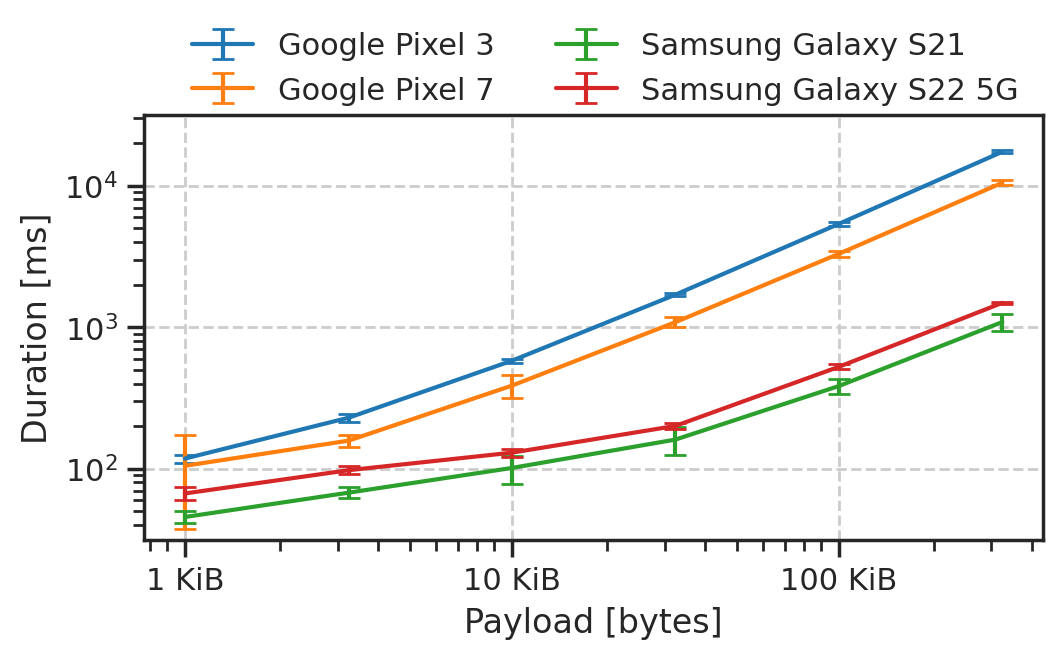

In [3]:
#
# Line plot with error bars for HMAC speed given payload size
#

def draw_plot_for_test(df, test_id):
    fig, ax = plt.subplots()
    fig.set_size_inches((5.5, 3.0))
    
    df = df[df.test == test_id]

    def draw_plot_for_name(data, ax, name):
        grouped = data[data.name==name][["duration", "size"]].groupby("size", as_index=False)

        means = grouped.mean()
        errors = grouped.std()

        handle = ax.errorbar(
            x=means["size"], y=means["duration"], yerr=errors["duration"],
            fmt='', ls='-',
            ms=5, capsize=4)
        handle.set_label(name)

    for name in sorted(list(set(df['name']))):
        draw_plot_for_name(df, ax, name)

    print(f"Operation: {test_id}")

    ax.set_xlabel("Payload [bytes]")
    ax.set_xscale("log")
    ax.set_xticks([1024, 10*1024, 100*1024])
    ax.set_xticklabels(["1 KiB", "10 KiB", "100 KiB"])

    ax.set_ylabel("Duration [ms]")
    ax.set_yscale("log")
    ax.set_ylim((math.sqrt(10)*10, math.sqrt(10)*10_000))

    ax.grid(ls='--')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(0.97, 1.125), frameon=False)

    fig.tight_layout()
    fig.savefig(f"output/android-se-bench-payload-size-and-time-{test_id}.pdf", bbox_inches='tight')

    
for test_id in ("hmacLong",):
    draw_plot_for_test(df, test_id)

,name,size,duration
1282,Samsung Galaxy S22 5G,129200,557.886191
411,Google Pixel 3,42100,2016.476317
1622,Samsung Galaxy S22 5G,163200,699.185086
877,Google Pixel 3,88700,4250.377359
1517,Samsung Galaxy S21,152700,323.592761
1901,Google Pixel 3,191100,9254.527256
1124,Google Pixel 7,113400,3010.409918
1966,Samsung Galaxy S21,197600,415.687227
2904,Samsung Galaxy S21,291400,613.947982
441,Samsung Galaxy S21,45100,110.294524


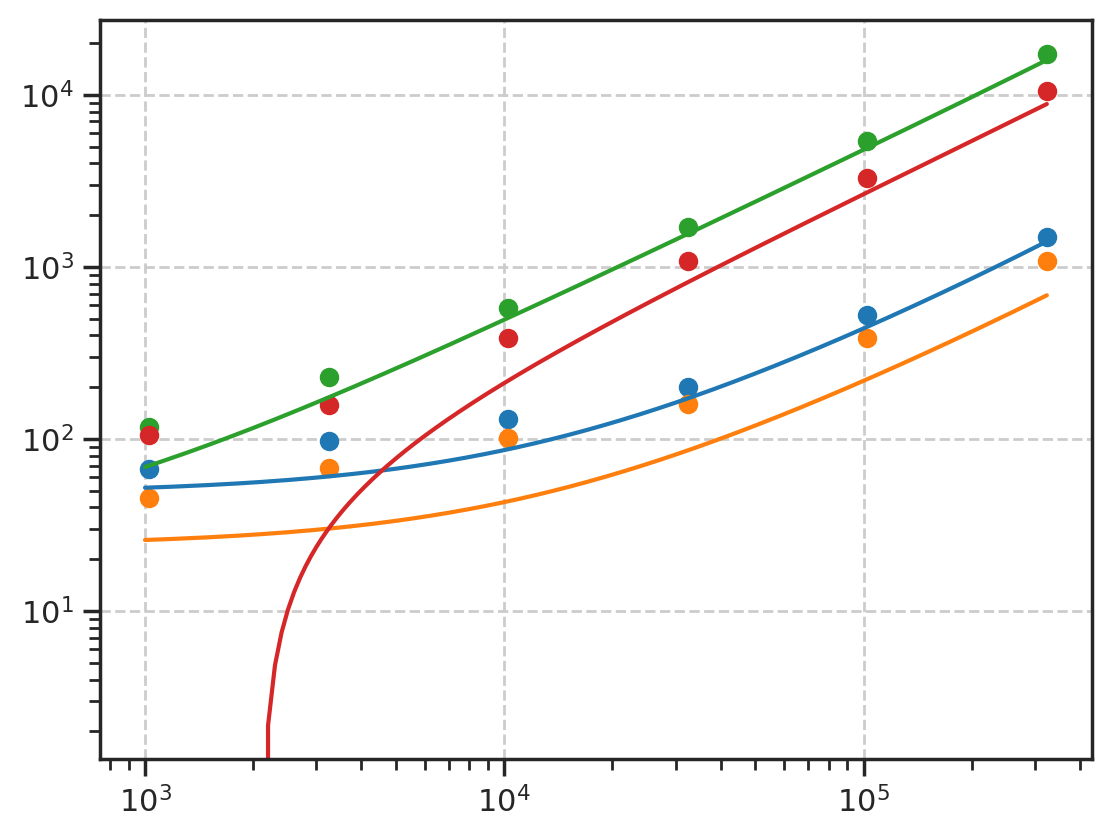

In [4]:
#
# Intermediate dataset with fitted curve values for Android
#

def proto_curve(x, a, b, c):
    return a * x**2 + b * x + c

output_dfs = []

for name in set(df['name']):
    groupped_df = df[(df.test == "hmacLong") & (df.name == name)][["size", "duration"]].groupby(["size"], as_index=False)
    xs = groupped_df.mean()['size']
    ys_original = groupped_df.mean()['duration']
    ys = groupped_df.min()['duration'] - 2 * groupped_df.std()['duration']
    
    params, _ = curve_fit(proto_curve, xs, ys)
    
    # output data points every 10 KiB
    assert min(xs) >= 1024
    xl = np.arange(1_000, max(xs), 100)
    yl = proto_curve(xl, params[0], params[1], params[2])
    
    # debug plot to verify results
    plt.plot(xl, yl)
    plt.scatter(xs, ys_original)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid('both', ls="--")
    
    output_dfs.append(pd.DataFrame(data={
        'name': name,
        'size': xl,
        'duration': yl,
    }))
    
output_dfs = pd.concat(output_dfs)
output_dfs.to_csv("output/android-fitted-durations.csv")
output_dfs.sample(10)